In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests
import cv2
from itertools import combinations


device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

INFO - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/config.json "HTTP/1.1 200 OK"
INFO - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/model.safetensors "HTTP/1.1 302 Found"
Loading weights: 100%|██████████| 1468/1468 [00:01<00:00, 1230.58it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       
INFO - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/processor_config.json "HTTP/1.1 200 OK"
INFO - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/preprocessor_config.json "HTTP/1.1 404 Not Found"
INFO - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/tokenizer_config.json "HTTP/1.1 200 OK"
INFO - HTTP Request: GET https://huggingface.co/api/models/facebook/sam3/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
INFO - HTTP Request: GET https://huggingface.co/api/models/facebook/sam3/tree/main?recursive=true

In [5]:
# list images in train_images/forged directory
import os

forged_dir = "train_images/forged"
authentic_dir = "train_images/authentic"
mask_dir = "train_masks"
forged_images = sorted([f for f in os.listdir(forged_dir)])
authentic_images = sorted([f for f in os.listdir(authentic_dir)])
forged_masks = sorted([f for f in os.listdir(mask_dir)])

print("number of forged images: ", len(forged_images))
print("number of authentic images: ", len(authentic_images))
print("number of forged masks: ", len(forged_masks))


number of forged images:  2751
number of authentic images:  2377
number of forged masks:  2751


In [6]:
forged_images[1700]

'45381.png'

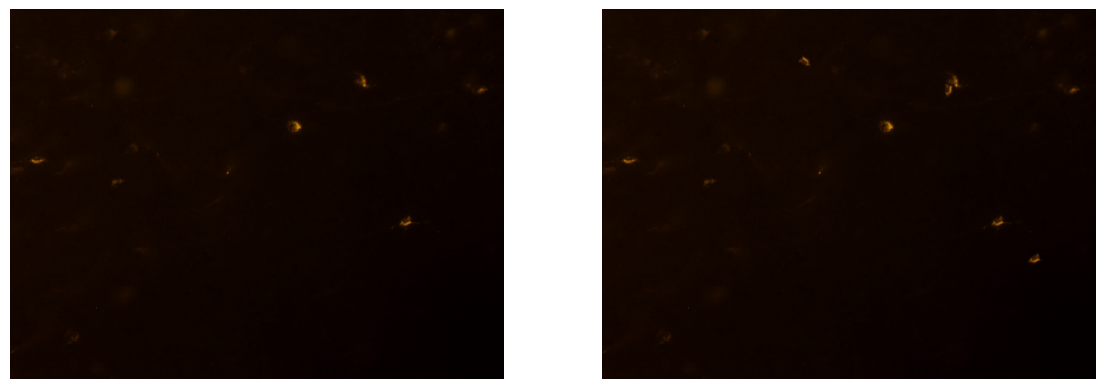

In [8]:
image_num = 1
auth_image = Image.open(authentic_dir + "/" + authentic_images[image_num])
image = Image.open(forged_dir + "/" + forged_images[image_num])
# show side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].imshow(auth_image)
axs[0].axis("off")
axs[1].imshow(image)
axs[1].axis("off")
plt.show()


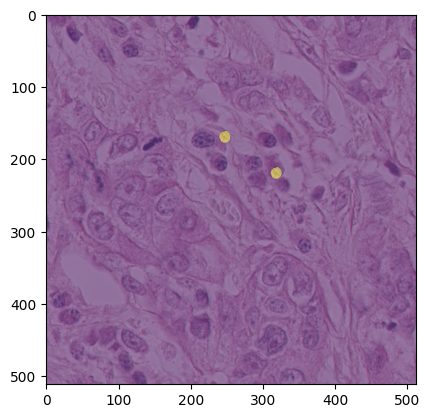

In [122]:
# load mask numpy file
mask_np = np.load(mask_dir + "/" + forged_masks[image_num])
mask_np = mask_np[0]

plt.imshow(image, cmap="gray")
plt.imshow(mask_np, alpha=0.5)
plt.show()

In [123]:
inputs = processor(images=image, text="distinct object", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

In [124]:
# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")


Found 61 objects


In [89]:
results.keys()
results["masks"].shape
# results["scores"]

torch.Size([198, 528, 512])

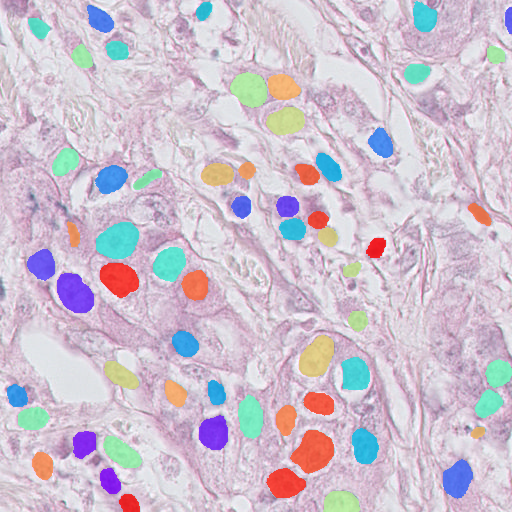

In [125]:
def overlay_masks(image, masks):
    image = image.convert("RGBA")
    masks = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    for mask, color in zip(masks, colors):
        mask = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask.point(lambda v: int(v * 0.8))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    return image
overlay_masks(image, results["masks"])


Closest pair: indices (12, 17), distance: 0.1526


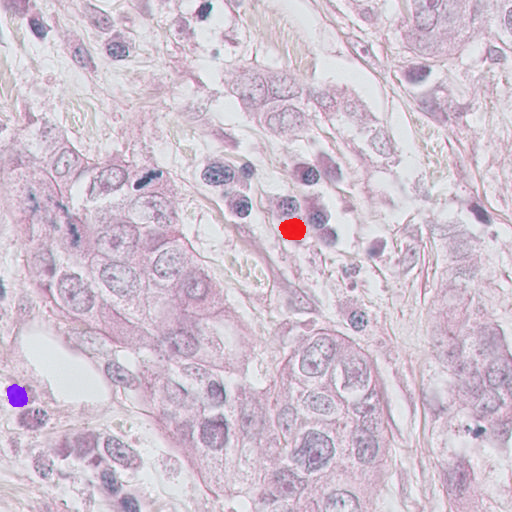

In [ ]:
# Build list of (mask, hu_moments)
mask_hu_list = []
for mask in results["masks"]:
    mask_np = mask.cpu().numpy().astype(np.uint8)
    moments = cv2.moments(mask_np)
    hu = cv2.HuMoments(moments).flatten()
    # Log-transform (standard practice for Hu moments)
    hu_log = np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    mask_hu_list.append((mask, hu_log))

# Find 2 closest
min_dist = float('inf')
closest_pair = None
second_closest_pair = None
for (i, (m1, h1)), (j, (m2, h2)) in combinations(enumerate(mask_hu_list), 2):
    dist = np.linalg.norm(h1 - h2)
    if dist < min_dist:
        min_dist = dist
        second_closest_pair = closest_pair
        closest_pair = (i, j)

pair_to_use = closest_pair
print(f"Closest pair: indices {pair_to_use}, distance: {min_dist:.4f}")
our_masks = torch.stack([mask_hu_list[pair_to_use[0]][0], mask_hu_list[pair_to_use[1]][0]])
overlay_masks(image, our_masks)


Most similar: (3, 26)


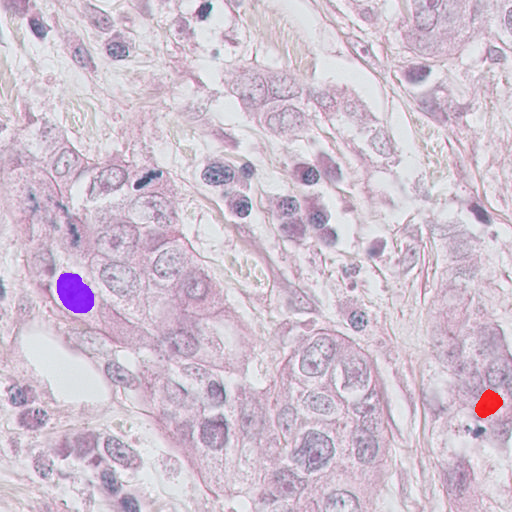

In [128]:
def get_color_hist(image, mask):
    img_np = np.array(image)
    mask_np = mask.cpu().numpy().astype(bool)
    pixels = img_np[mask_np]
    hist, _ = np.histogramdd(pixels, bins=8, range=[(0,256)]*3)
    return hist.flatten() / hist.sum()

hists = [get_color_hist(image, m) for m in results["masks"]]

# Find closest (smaller distance = more similar)
min_dist = float('inf')
best_pair = None
for i, j in combinations(range(len(hists)), 2):
    dist = np.linalg.norm(hists[i] - hists[j])
    if dist < min_dist:
        min_dist = dist
        best_pair = (i, j)

print(f"Most similar: {best_pair}")
our_masks = torch.stack([mask_hu_list[best_pair[0]][0], mask_hu_list[best_pair[1]][0]])
overlay_masks(image, our_masks)


Loading weights: 100%|██████████| 398/398 [00:00<00:00, 1220.61it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Most similar: (45, 55), similarity: 0.9919


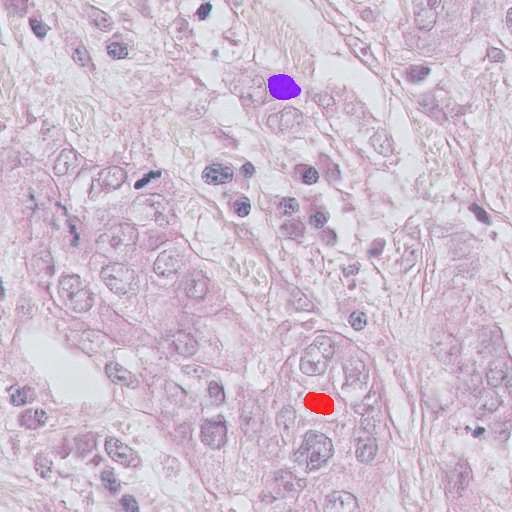

In [129]:
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_masked_crop(image, mask):
    """Extract bounding box crop of masked region"""
    mask_np = mask.cpu().numpy()
    ys, xs = np.where(mask_np)
    if len(xs) == 0:
        return None
    crop = image.crop((xs.min(), ys.min(), xs.max(), ys.max()))
    return crop

# Get embeddings for each object
embeddings = []
for mask in results["masks"]:
    crop = get_masked_crop(image, mask)
    if crop is None:
        embeddings.append(None)
        continue
    inputs = clip_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
    embeddings.append(emb[0].cpu().numpy())

# Find most similar pair (cosine similarity)
from itertools import combinations

max_sim = -float('inf')
best_pair = None
for i, j in combinations(range(len(embeddings)), 2):
    if embeddings[i] is None or embeddings[j] is None:
        continue
    sim = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
    if sim > max_sim:
        max_sim = sim
        best_pair = (i, j)

print(f"Most similar: {best_pair}, similarity: {max_sim:.4f}")
our_masks = torch.stack([mask_hu_list[best_pair[0]][0], mask_hu_list[best_pair[1]][0]])
overlay_masks(image, our_masks)

Valid objects: 61
Most similar: (14, 46), distance: 0.1455


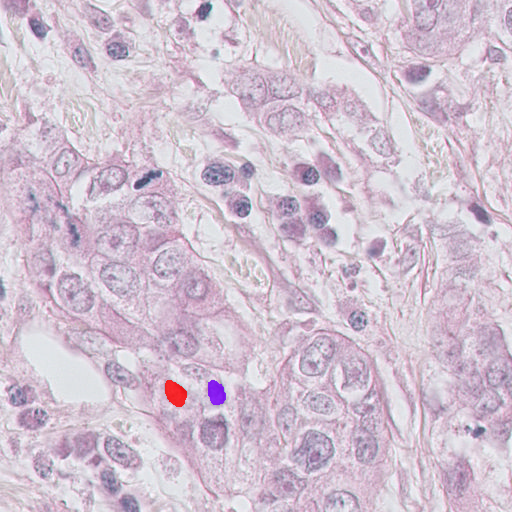

In [130]:
def get_color_moments(image, mask):
    """Extract brightness-invariant color moments using LAB a,b channels"""
    img_np = np.array(image.convert("RGB"))
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB).astype(np.float32)
    mask_np = mask.cpu().numpy().astype(bool)
    
    pixels = lab[mask_np][:, 1:]  # a,b channels only
    
    if len(pixels) < 2:
        return None
    
    # Just mean and std (skip skew - causes issues)
    moments = []
    for ch in range(2):
        ch_vals = pixels[:, ch]
        moments.extend([ch_vals.mean(), ch_vals.std()])
    return np.array(moments)  # 4 values

def get_shape_moments(mask):
    mask_np = mask.cpu().numpy().astype(np.uint8)
    hu = cv2.HuMoments(cv2.moments(mask_np)).flatten()
    return np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

# Extract features, filter out invalid ones
features = []
for i, m in enumerate(results["masks"]):
    shape = get_shape_moments(m)
    color = get_color_moments(image, m)
    if color is not None:
        features.append((i, shape, color))

print(f"Valid objects: {len(features)}")

# Normalize
shape_feats = np.array([f[1] for f in features])
color_feats = np.array([f[2] for f in features])

shape_norm = (shape_feats - shape_feats.mean(0)) / (shape_feats.std(0) + 1e-10)
color_norm = (color_feats - color_feats.mean(0)) / (color_feats.std(0) + 1e-10)

# Combine
shape_weight, color_weight = 0.95, 0.05
combined = np.hstack([shape_weight * shape_norm, color_weight * color_norm])

# Find most similar
from itertools import combinations

min_dist = float('inf')
best_pair = None
for a, b in combinations(range(len(features)), 2):
    dist = np.linalg.norm(combined[a] - combined[b])
    if dist < min_dist:
        min_dist = dist
        best_pair = (features[a][0], features[b][0])  # original indices

print(f"Most similar: {best_pair}, distance: {min_dist:.4f}")
our_masks = torch.stack([mask_hu_list[best_pair[0]][0], mask_hu_list[best_pair[1]][0]])
overlay_masks(image, our_masks)


In [131]:
def get_masked_crop_gray(image, mask):
    """Extract grayscale crop of masked region with alpha"""
    img_np = np.array(image.convert("RGB"))
    mask_np = mask.cpu().numpy().astype(np.uint8)
    
    ys, xs = np.where(mask_np)
    if len(xs) < 10:
        return None, None
    
    x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
    crop = img_np[y1:y2, x1:x2]
    mask_crop = mask_np[y1:y2, x1:x2]
    
    # Apply mask (set background to 0)
    gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
    gray = gray * mask_crop
    return gray, mask_crop

# ORB detector
orb = cv2.ORB_create(nfeatures=500)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Extract keypoints/descriptors for each object
obj_data = []
for i, m in enumerate(results["masks"]):
    gray, mask_crop = get_masked_crop_gray(image, m)
    if gray is None or gray.shape[0] < 10 or gray.shape[1] < 10:
        continue
    kp, des = orb.detectAndCompute(gray, mask_crop)
    if des is not None and len(des) >= 5:
        obj_data.append((i, kp, des, gray))

print(f"Objects with features: {len(obj_data)}")

# Find best matching pair
from itertools import combinations

best_match_count = 0
best_pair = None
for (i, kp1, des1, g1), (j, kp2, des2, g2) in combinations(obj_data, 2):
    matches = bf.match(des1, des2)
    # Count good matches (low distance)
    good = [m for m in matches if m.distance < 50]
    if len(good) > best_match_count:
        best_match_count = len(good)
        best_pair = (i, j)

print(f"Best pair: {best_pair}, matching features: {best_match_count}")
our_masks = torch.stack([mask_hu_list[best_pair[0]][0], mask_hu_list[best_pair[1]][0]])
overlay_masks(image, our_masks)

Objects with features: 0
Best pair: None, matching features: 0


TypeError: 'NoneType' object is not subscriptable

Valid objects: 61
Top 5 by shape similarity:
  (29, 46): hu_dist = 0.1526
  (12, 17): hu_dist = 0.1698
  (3, 18): hu_dist = 0.1783
  (39, 49): hu_dist = 0.2079
  (25, 57): hu_dist = 0.2115

Best copy-move candidate: (42, 46), correlation: 0.8142


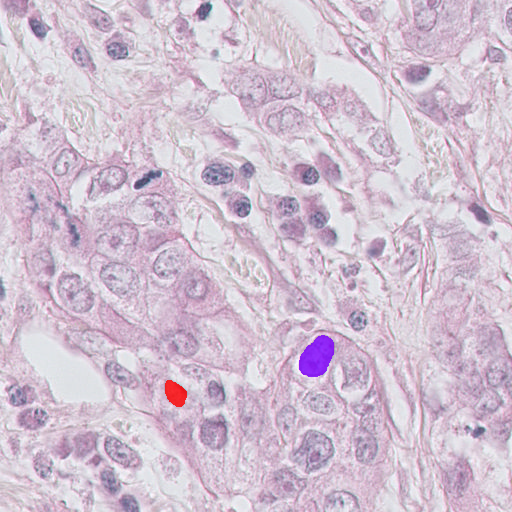

In [132]:
from itertools import combinations

def get_shape_moments(mask):
    mask_np = mask.cpu().numpy().astype(np.uint8)
    hu = cv2.HuMoments(cv2.moments(mask_np)).flatten()
    return np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

def get_crop_normalized(image, mask):
    """Get masked crop, resize to fixed size, normalize brightness"""
    img_np = np.array(image.convert("RGB"))
    mask_np = mask.cpu().numpy().astype(np.uint8)
    
    ys, xs = np.where(mask_np)
    if len(xs) < 5:
        return None
    
    x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
    crop = img_np[y1:y2, x1:x2].astype(np.float32)
    mask_crop = mask_np[y1:y2, x1:x2]
    
    # Resize to fixed size for comparison
    crop = cv2.resize(crop, (64, 64))
    mask_crop = cv2.resize(mask_crop, (64, 64))
    
    # Normalize to 0-1, subtract mean (brightness invariant)
    gray = cv2.cvtColor(crop.astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)
    gray = gray * (mask_crop > 0.5)
    if gray.max() > 0:
        gray = (gray - gray[mask_crop > 0.5].mean()) / (gray.std() + 1e-10)
    return gray

# Extract features
obj_data = []
for i, m in enumerate(results["masks"]):
    hu = get_shape_moments(m)
    crop = get_crop_normalized(image, m)
    if crop is not None:
        obj_data.append((i, hu, crop))

print(f"Valid objects: {len(obj_data)}")

# Stage 1: Find top 20 pairs by Hu moment similarity
hu_pairs = []
for (i, hu1, c1), (j, hu2, c2) in combinations(obj_data, 2):
    hu_dist = np.linalg.norm(hu1 - hu2)
    hu_pairs.append((hu_dist, i, j, c1, c2))

hu_pairs.sort(key=lambda x: x[0])
top_candidates = hu_pairs[:20]

print("Top 5 by shape similarity:")
for dist, i, j, _, _ in top_candidates[:5]:
    print(f"  ({i}, {j}): hu_dist = {dist:.4f}")

# Stage 2: Among shape-similar pairs, find best pixel correlation
best_corr = -1
best_pair = None
for hu_dist, i, j, c1, c2 in top_candidates:
    # Try both orientations (original and flipped)
    corr1 = np.corrcoef(c1.flatten(), c2.flatten())[0, 1]
    corr2 = np.corrcoef(c1.flatten(), np.flip(c2, axis=1).flatten())[0, 1]
    corr = max(corr1, corr2)
    if corr > best_corr:
        best_corr = corr
        best_pair = (i, j)

print(f"\nBest copy-move candidate: {best_pair}, correlation: {best_corr:.4f}")
our_masks = torch.stack([mask_hu_list[best_pair[0]][0], mask_hu_list[best_pair[1]][0]])
overlay_masks(image, our_masks)

Top 10 most similar pairs (by image content):
  (32, 40): hash distance = 10
  (1, 25): hash distance = 14
  (18, 60): hash distance = 14
  (11, 26): hash distance = 18
  (11, 37): hash distance = 18
  (18, 44): hash distance = 18
  (23, 30): hash distance = 18
  (41, 46): hash distance = 18
  (47, 60): hash distance = 18
  (56, 60): hash distance = 18


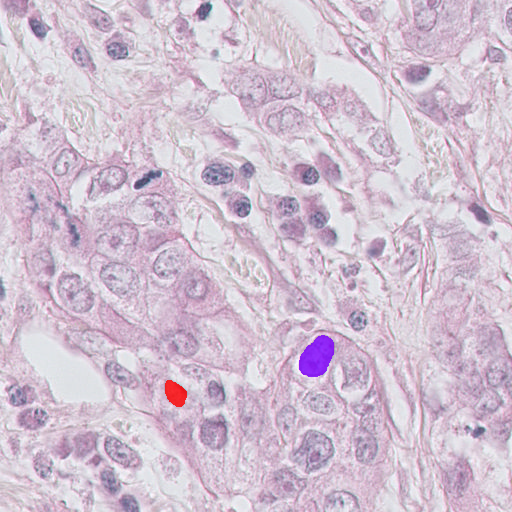

In [133]:
import imagehash
from PIL import Image

def get_bbox_crop(image, mask):
    """Get bounding box crop of the IMAGE (not masked)"""
    mask_np = mask.cpu().numpy().astype(np.uint8)
    ys, xs = np.where(mask_np)
    if len(xs) < 5:
        return None
    x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
    return image.crop((x1, y1, x2, y2))

# Get perceptual hash for each object's region
obj_hashes = []
for i, m in enumerate(results["masks"]):
    crop = get_bbox_crop(image, m)
    if crop is None or crop.size[0] < 5 or crop.size[1] < 5:
        obj_hashes.append((i, None))
        continue
    # Resize to square for fair comparison
    crop_resized = crop.resize((64, 64))
    phash = imagehash.phash(crop_resized)
    obj_hashes.append((i, phash))

# Find pairs with smallest hash distance (most similar images)
from itertools import combinations

pairs_by_dist = []
for (i, h1), (j, h2) in combinations(obj_hashes, 2):
    if h1 is None or h2 is None:
        continue
    dist = h1 - h2  # Hamming distance
    pairs_by_dist.append((dist, i, j))

pairs_by_dist.sort(key=lambda x: x[0])

print("Top 10 most similar pairs (by image content):")
for dist, i, j in pairs_by_dist[:10]:
    print(f"  ({i}, {j}): hash distance = {dist}")
our_masks = torch.stack([mask_hu_list[best_pair[0]][0], mask_hu_list[best_pair[1]][0]])
overlay_masks(image, our_masks)